# Data upload

In [71]:
# !pip install sqlalchemy python-dotenv kagglehub pymysql cryptography


import pandas as pd
import sqlalchemy as sqla
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from dotenv import load_dotenv



In [72]:
# load dotenv file for database connectino
load_dotenv()

#create database enginge from dotenv info
def get_uri_from_env():
    user = os.getenv("MYSQL_USER")  
    password = os.getenv("MYSQL_PASSWORD")
    host = os.getenv("MYSQL_HOST")
    port = os.getenv("MYSQL_PORT")
    db = os.getenv("MYSQL_DB")
    return f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}'

uri = get_uri_from_env()

engine = sqla.create_engine(uri)


In [73]:
# download data from kagglehub
path = kagglehub.dataset_download("joycemara/european-fashion-store-multitable-dataset")

tables = [
    'dataset_fashion_store_customers',
    'dataset_fashion_store_sales',
    'dataset_fashion_store_salesitems',
    'dataset_fashion_store_products',
    'dataset_fashion_store_stock',
    'dataset_fashion_store_campaigns',
    'dataset_fashion_store_channels'
]


In [74]:
# load the kaggle data to the sql database runnning in the engine
for table in tables:
    file_path = os.path.join(path, f"{table}.csv")
    print(file_path)
    df = pd.read_csv(file_path)
    # rename tables for convinience
    table = table.replace("dataset_fashion_store_", "")
    df.to_sql(table, engine, if_exists='replace', index=False, schema='dataset_fashion_store')

C:\Users\Friedrich\.cache\kagglehub\datasets\joycemara\european-fashion-store-multitable-dataset\versions\3\dataset_fashion_store_customers.csv
C:\Users\Friedrich\.cache\kagglehub\datasets\joycemara\european-fashion-store-multitable-dataset\versions\3\dataset_fashion_store_sales.csv
C:\Users\Friedrich\.cache\kagglehub\datasets\joycemara\european-fashion-store-multitable-dataset\versions\3\dataset_fashion_store_salesitems.csv
C:\Users\Friedrich\.cache\kagglehub\datasets\joycemara\european-fashion-store-multitable-dataset\versions\3\dataset_fashion_store_products.csv
C:\Users\Friedrich\.cache\kagglehub\datasets\joycemara\european-fashion-store-multitable-dataset\versions\3\dataset_fashion_store_stock.csv
C:\Users\Friedrich\.cache\kagglehub\datasets\joycemara\european-fashion-store-multitable-dataset\versions\3\dataset_fashion_store_campaigns.csv
C:\Users\Friedrich\.cache\kagglehub\datasets\joycemara\european-fashion-store-multitable-dataset\versions\3\dataset_fashion_store_channels.csv


# Answering the Business Questions
## Identify best selling product category by the amount of items sold

   sale_year   category  total_items_sold
0       2025    Dresses            1451.0
1       2025   T-Shirts            1439.0
2       2025      Shoes            1400.0
3       2025  Sleepwear            1362.0
4       2025      Pants            1063.0


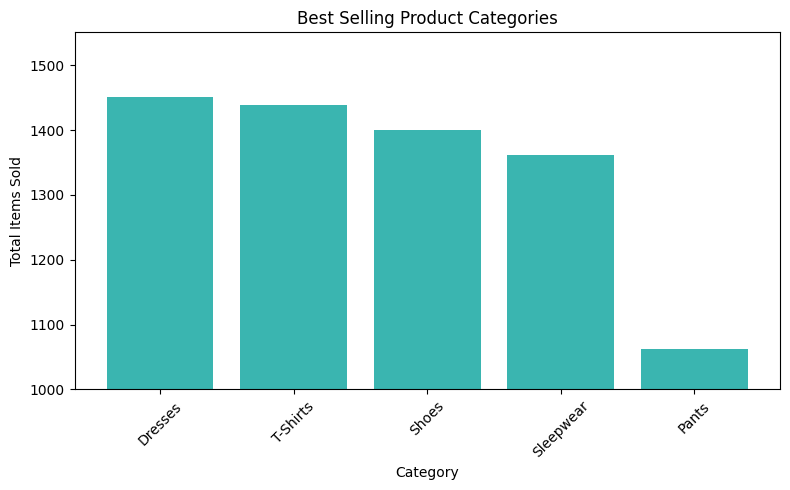

In [75]:
# identify best selling product category by the amount of items sold
df = pd.read_sql_query(
    """
    SELECT 
        EXTRACT(YEAR FROM si.sale_date) AS sale_year,
        p.category,
        SUM(si.quantity) AS total_items_sold
    FROM
        dataset_fashion_store.salesitems AS si
    JOIN dataset_fashion_store.products AS p
        ON p.product_id = si.product_id
    GROUP BY p.category, sale_year
    ORDER BY total_items_sold DESC
    
    """,
    engine
)
print(df)


plt.figure(figsize=(8, 5))
plt.bar(df['category'], df['total_items_sold'], color='#3AB5B0') 
plt.title('Best Selling Product Categories')
plt.ylim(1000, df['total_items_sold'].max() + 100) 
plt.xlabel('Category')
plt.ylabel('Total Items Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the sales over time

In [76]:
# Display the sales over time

# created a VIEW in MySQL Workbench to make python selection easier:
"""
CREATE OR REPLACE VIEW monthly_running_total AS 
	WITH RECURSIVE calendar AS (
	  SELECT DATE('2025-04-01') AS calendar_date
	  UNION ALL
	  SELECT DATE_ADD(calendar_date, INTERVAL 1 DAY)
	  FROM calendar
	  WHERE calendar_date <  DATE('2025-06-01')
	)
	SELECT 
		c.calendar_date,
		IFNULL(SUM(si.quantity), 0) AS daily_total,
		SUM(IFNULL(SUM(si.quantity), 0)) OVER (
		  PARTITION BY YEAR(c.calendar_date), MONTH(c.calendar_date)
		  ORDER BY c.calendar_date
		) AS running_total
	FROM 
		calendar c
	LEFT JOIN sales s ON DATE(s.sale_date) = c.calendar_date
	LEFT JOIN salesitems si ON s.sale_id = si.sale_id
	GROUP BY c.calendar_date
	ORDER BY c.calendar_date;
"""

"\nCREATE OR REPLACE VIEW monthly_running_total AS \n\tWITH RECURSIVE calendar AS (\n\t  SELECT DATE('2025-04-01') AS calendar_date\n\t  UNION ALL\n\t  SELECT DATE_ADD(calendar_date, INTERVAL 1 DAY)\n\t  FROM calendar\n\t  WHERE calendar_date <  DATE('2025-06-01')\n\t)\n\tSELECT \n\t\tc.calendar_date,\n\t\tIFNULL(SUM(si.quantity), 0) AS daily_total,\n\t\tSUM(IFNULL(SUM(si.quantity), 0)) OVER (\n\t\t  PARTITION BY YEAR(c.calendar_date), MONTH(c.calendar_date)\n\t\t  ORDER BY c.calendar_date\n\t\t) AS running_total\n\tFROM \n\t\tcalendar c\n\tLEFT JOIN sales s ON DATE(s.sale_date) = c.calendar_date\n\tLEFT JOIN salesitems si ON s.sale_id = si.sale_id\n\tGROUP BY c.calendar_date\n\tORDER BY c.calendar_date;\n"

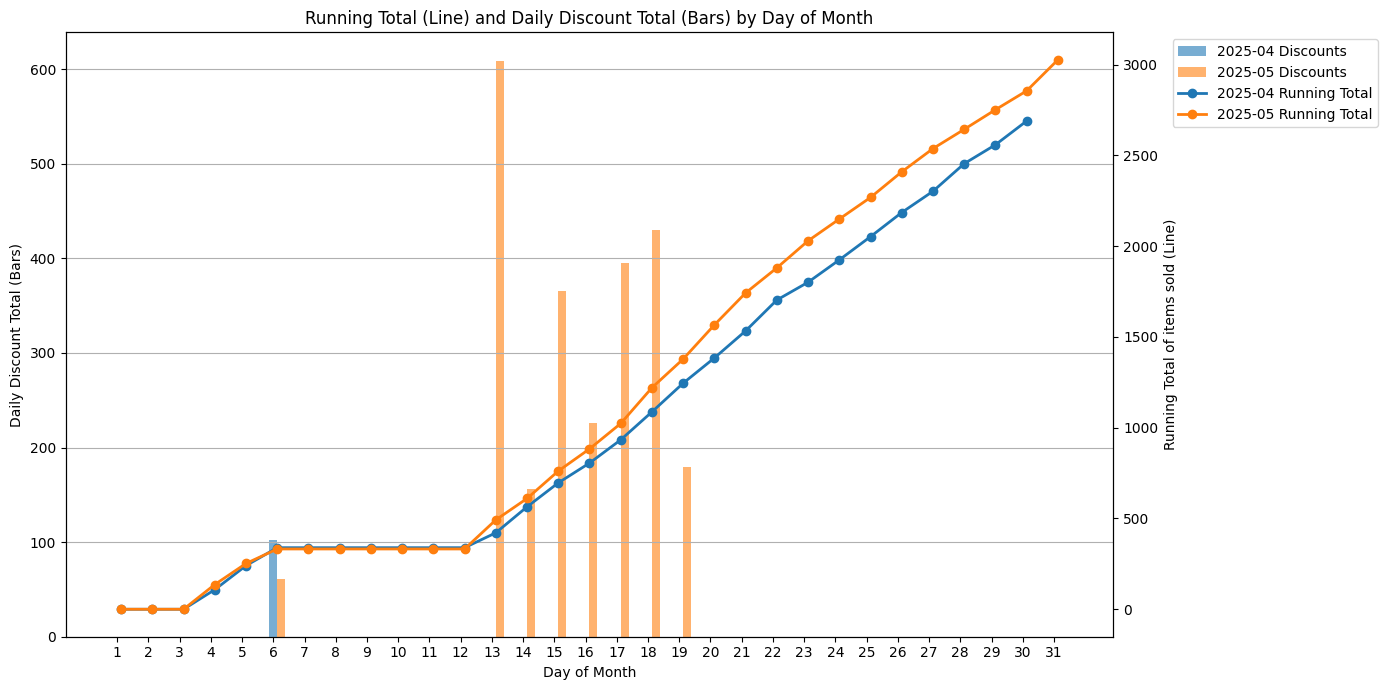

In [118]:
# -- Display the sales over time
# -- Because there are only three months of data the running total of all months can be displayed in one chart and the months can be compared
df = pd.read_sql_query(
    """
    
    SELECT * FROM dataset_fashion_store.monthly_running_total;
		
    """,
    engine
)
# Load your data (already done)
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# Extract month-year and day of month
df['month_year'] = df['calendar_date'].dt.to_period('M').astype(str)
df['day'] = df['calendar_date'].dt.day

# Pivot running_total for line plot
running_pivot = df.pivot(index='day', columns='month_year', values='running_total')

# Pivot daily_discount_total for bar plot
discount_pivot = df.pivot(index='day', columns='month_year', values='daily_discount_total')

# Set up colors
palette = sns.color_palette("tab10", n_colors=len(running_pivot.columns))

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot bars (discounts) with some transparency for overlap
bar_width = 0.25
for i, month in enumerate(discount_pivot.columns):
    ax1.bar(discount_pivot.index + i * bar_width, discount_pivot[month], 
            width=bar_width, alpha=0.6, label=f"{month} Discounts", color=palette[i])

ax1.set_xlabel('Day of Month')
ax1.set_ylabel('Daily Discount Total (Bars)')
ax1.set_xticks(range(1, 32))
ax1.grid(True, axis='y')

# Create second y-axis for running total line plot
ax2 = ax1.twinx()

for i, month in enumerate(running_pivot.columns):
    ax2.plot(running_pivot.index + bar_width/2, running_pivot[month], 
             marker='o', label=f"{month} Running Total", color=palette[i], linewidth=2)

ax2.set_ylabel('Running Total of items sold (Line)')
ax2.grid(False)

# Combine legends from both axes
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Running Total (Line) and Daily Discount Total (Bars) by Day of Month')
plt.tight_layout()
plt.show()

# What is the average orderbank reach of each product? 
- i.e. for how many months is the stock sufficient (calculating with an average monthly sales)?
- which products should be restocked? HOW many products need to be restocked?
- criteria for restocking is that the orderbank reach is less than 2 months

In [78]:
# -- what is the average orderbank reach of each product? 
# -- i.e. for how many months is the stock sufficient (calculating with an average monthly sales)?
# -- which products should be restocked? HOW many products need to be restocked?
# -- criteria for restocking is that the orderbank reach is less than 2 months

# created a VIEW in MySQL Workbench to make python selection easier:
"""
CREATE OR REPLACE VIEW order_bank_reach AS
WITH avg_monthly_quantity AS (
	-- Calculate the average monthly quantity sold per product
	SELECT 
		product_id,
		ROUND(AVG(monthly_total), 2) AS avg_monthly_quantity
		FROM
		(
			-- Calculate total quantity sold per product for each month
			SELECT 
				product_id,
				DATE_FORMAT(s.sale_date, '%Y-%m') AS sale_month,
				SUM(si.quantity) AS monthly_total
			FROM 
				salesitems si
			JOIN sales s ON s.sale_id = si.sale_id
			GROUP BY 
				sale_month, product_id
			)AS monthly_data
	GROUP BY product_id
),

total_stock AS (
	-- Sum total stock quantity across warehouses (e.g., Germany and France)
	SELECT
		product_id,
		SUM(stock_quantity) as total_stock_quantity
	FROM
		stock
	GROUP BY product_id
),
order_bank_reach as (
 -- Calculate how many months the current stock can cover based on average monthly sales
	SELECT 
		st.product_id,
        avg_monthly_quantity.avg_monthly_quantity,
        st.total_stock_quantity,
		total_stock_quantity / avg_monthly_quantity as order_bank_reach
	FROM avg_monthly_quantity
	JOIN total_stock as st
	ON st.product_id = avg_monthly_quantity.product_id

	ORDER BY total_stock_quantity / avg_monthly_quantity  ASC
)
-- Final selection joining product details
select order_bank_reach.avg_monthly_quantity,
       order_bank_reach.total_stock_quantity,
       order_bank_reach.order_bank_reach,
       p.*
FROM order_bank_reach
JOIN products as p
ON p.product_id = order_bank_reach.product_id
"""

"\nCREATE OR REPLACE VIEW order_bank_reach AS\nWITH avg_monthly_quantity AS (\n\t-- Calculate the average monthly quantity sold per product\n\tSELECT \n\t\tproduct_id,\n\t\tROUND(AVG(monthly_total), 2) AS avg_monthly_quantity\n\t\tFROM\n\t\t(\n\t\t\t-- Calculate total quantity sold per product for each month\n\t\t\tSELECT \n\t\t\t\tproduct_id,\n\t\t\t\tDATE_FORMAT(s.sale_date, '%Y-%m') AS sale_month,\n\t\t\t\tSUM(si.quantity) AS monthly_total\n\t\t\tFROM \n\t\t\t\tsalesitems si\n\t\t\tJOIN sales s ON s.sale_id = si.sale_id\n\t\t\tGROUP BY \n\t\t\t\tsale_month, product_id\n\t\t\t)AS monthly_data\n\tGROUP BY product_id\n),\n\ntotal_stock AS (\n\t-- Sum total stock quantity across warehouses (e.g., Germany and France)\n\tSELECT\n\t\tproduct_id,\n\t\tSUM(stock_quantity) as total_stock_quantity\n\tFROM\n\t\tstock\n\tGROUP BY product_id\n),\norder_bank_reach as (\n -- Calculate how many months the current stock can cover based on average monthly sales\n\tSELECT \n\t\tst.product_id,\n        

# Identify and count the products in need of restocking 

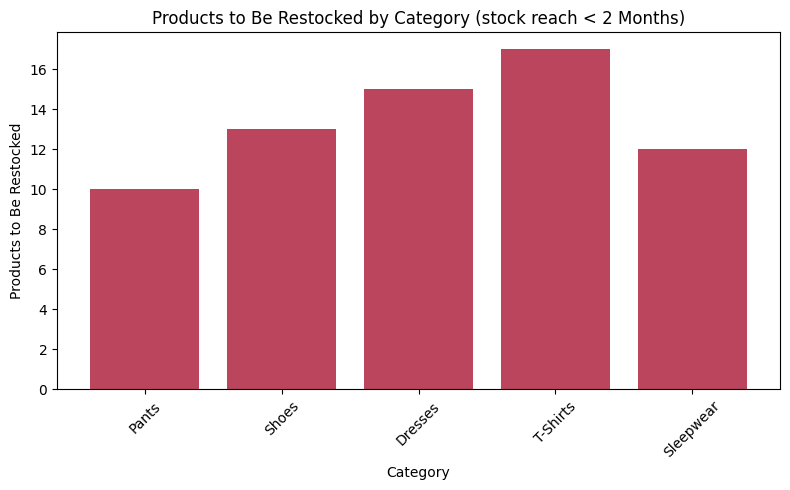

In [119]:
# Identify and count the products in need of restocking 
df = pd.read_sql_query(
    """
    
    SELECT category,
		COUNT(*) AS products_to_be_restocked 
	FROM dataset_fashion_store.order_bank_reach
	WHERE order_bank_reach < 2
	GROUP BY category
		
    """,
    engine
)
plt.figure(figsize=(8, 5))
plt.bar(df['category'], df['products_to_be_restocked'], color='#BC455E') 
plt.title('Products to Be Restocked by Category (stock reach < 2 Months)')
plt.xlabel('Category')
plt.ylabel('Products to Be Restocked')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# What is the average orderbank reach? (Stock Reach = total stock / avg monthly sales)

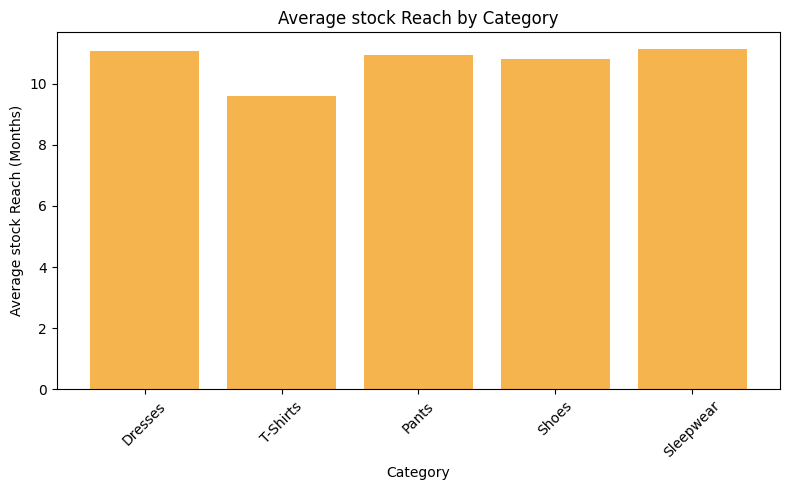

In [ ]:
# What is the average orderbank reach? (orderbank Reach = total stock / avg monthly sales)

df = pd.read_sql_query(
"""
    SELECT 
        category,
        AVG(order_bank_reach)
    FROM dataset_fashion_store.order_bank_reach
    GROUP BY category
    ;

""",
    engine
)
plt.figure(figsize=(8, 5))
plt.bar(df['category'], df['AVG(order_bank_reach)'], color='#F6B44F') 
plt.title('Average stock Reach by Category')
plt.xlabel('Category')
plt.ylabel('Average stock Reach (Months)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify the products with a high order bank reach and high margins in order to be included in the next sales campaign 
- The Items should have an orderbank reach of 1.5 the average of the category 
- and after a discount of 10% still have an above average margin for their category

In [81]:
# Identify the products with a high order bank reach and high margins in order to be included in the next sales campaign 
# The Items should have an orderbank reach of 1.5 the average of the category and after a discount of 10% still have an above average margin for their category

# created a VIEW in MySQL Workbench to make python selection easier:

"""
CREATE OR REPLACE VIEW products_for_next_sales_campain_high_proft AS
	WITH product_margins AS (
		-- Add margin and discounted margin to the orderbank reach view
		SELECT 
			*,
			ROUND((catalog_price - cost_price) / catalog_price, 2) AS margin,
			ROUND(((catalog_price * 0.90) - cost_price) / (catalog_price * 0.90), 2) AS discounted_margin -- 10 % discount
		FROM 
			order_bank_reach
	),
	category_avg_margins AS (
		-- calculate the average margin of each category
		SELECT
			category,
			ROUND(AVG(margin), 2) AS category_avg_margin
		FROM product_margins
		GROUP BY category
	),
	category_avg_obr AS (
		-- calculate the average Order Bank reach of each category
		SELECT 
			category,
			AVG(order_bank_reach) as category_avg_obr
		FROM order_bank_reach
		GROUP BY category
	)
	SELECT 
		pm.*, 
		cam.category_avg_margin,
		cao.category_avg_obr
	FROM product_margins pm
	JOIN category_avg_margins cam
	  ON pm.category = cam.category
	JOIN category_avg_obr cao
	  ON cao.category = pm.category
	WHERE pm.discounted_margin > cam.category_avg_margin 
	  AND cao.category_avg_obr < pm.order_bank_reach;
"""

'\nCREATE OR REPLACE VIEW products_for_next_sales_campain_high_proft AS\n\tWITH product_margins AS (\n\t\t-- Add margin and discounted margin to the orderbank reach view\n\t\tSELECT \n\t\t\t*,\n\t\t\tROUND((catalog_price - cost_price) / catalog_price, 2) AS margin,\n\t\t\tROUND(((catalog_price * 0.90) - cost_price) / (catalog_price * 0.90), 2) AS discounted_margin -- 10 % discount\n\t\tFROM \n\t\t\torder_bank_reach\n\t),\n\tcategory_avg_margins AS (\n\t\t-- calculate the average margin of each category\n\t\tSELECT\n\t\t\tcategory,\n\t\t\tROUND(AVG(margin), 2) AS category_avg_margin\n\t\tFROM product_margins\n\t\tGROUP BY category\n\t),\n\tcategory_avg_obr AS (\n\t\t-- calculate the average Order Bank reach of each category\n\t\tSELECT \n\t\t\tcategory,\n\t\t\tAVG(order_bank_reach) as category_avg_obr\n\t\tFROM order_bank_reach\n\t\tGROUP BY category\n\t)\n\tSELECT \n\t\tpm.*, \n\t\tcam.category_avg_margin,\n\t\tcao.category_avg_obr\n\tFROM product_margins pm\n\tJOIN category_avg_margin

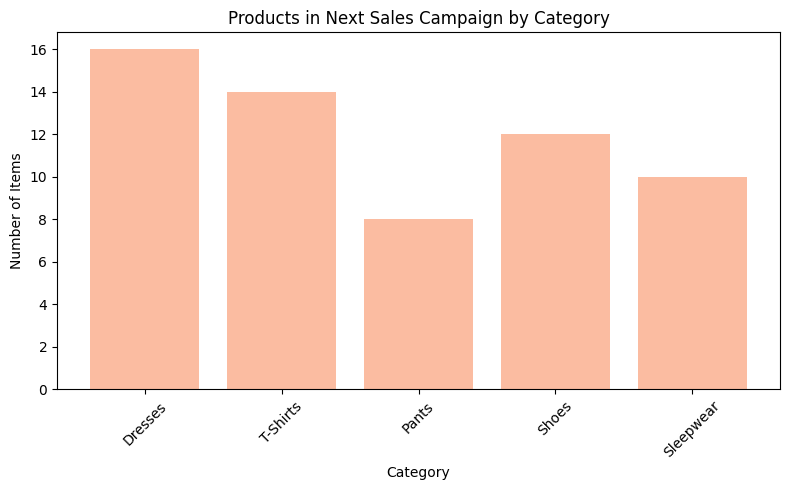

In [87]:
df = pd.read_sql_query(
"""
    SELECT 
        category, 
        COUNT(*) as products_in_next_sales_campain  
    FROM dataset_fashion_store.products_for_next_sales_campain_high_proft
    GROUP BY category;

""",
    engine
)
plt.figure(figsize=(8, 5))
plt.bar(df['category'], df['products_in_next_sales_campain'], color='#FBBCA1') 
plt.title('Products in Next Sales Campaign by Category')
plt.xlabel('Category')
plt.ylabel('Number of Items')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Are there any products in stock with above average orderbank reach (2,5 x avg of category)?

In [ ]:
# -- Are there any products in stock with above average orderbank reach (2,5 x avg of category)?
# created a VIEW in MySQL Workbench to make python selection easier:

"""
CREATE OR REPLACE VIEW products_for_next_sales_campain_high_stock AS
	WITH category_avg_obr AS (
		-- calculate the average Order Bank reach of each category
		SELECT 
			category,
			AVG(order_bank_reach) as category_avg_obr
		FROM order_bank_reach
		GROUP BY category
	)
	SELECT 
		obr.*, 		
		cao.category_avg_obr
	FROM order_bank_reach obr	
	JOIN category_avg_obr cao
	  ON cao.category = obr.category
	WHERE 2.5 * cao.category_avg_obr < obr.order_bank_reach;
"""

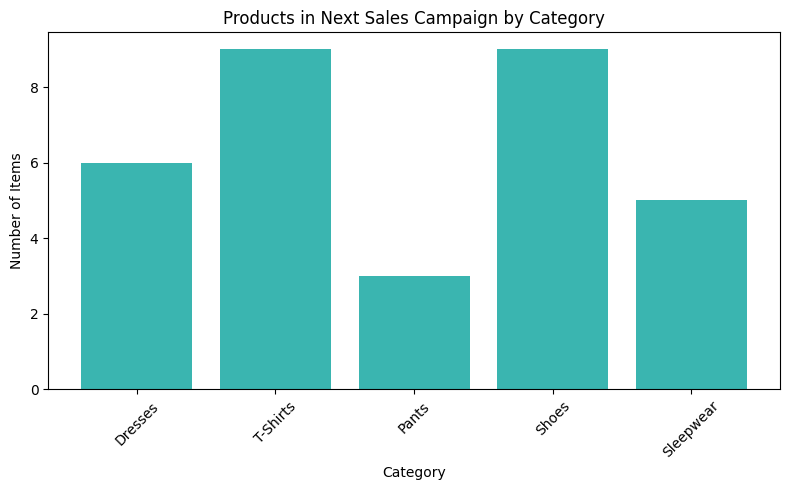

In [91]:
df = pd.read_sql_query(
"""
    SELECT 
        category, 
        COUNT(*) as products_in_next_sales_campain  
    FROM 
        dataset_fashion_store.products_for_next_sales_campain_high_stock
    GROUP BY category;

""",
    engine
)
plt.figure(figsize=(8, 5))
plt.bar(df['category'], df['products_in_next_sales_campain'], color='#3AB5B0') 
plt.title('Products in Next Sales Campaign by Category')
plt.xlabel('Category')
plt.ylabel('Number of Items')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify the most effective sales channel to be focused in the next campaign
-  i.e. the Channel with the highest amount of sales

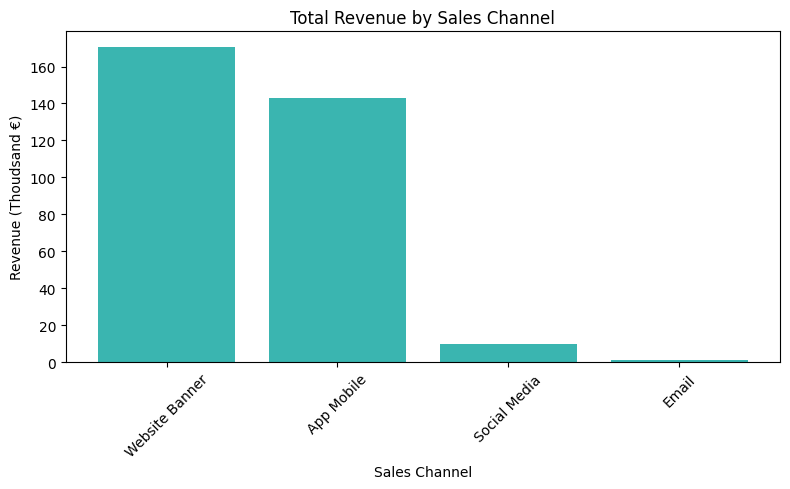

In [85]:
# -- ----------------------------------------------------------------------------------------------------------------------------------
# -- Identify the most effective sales channel to be focused in the next campaign
# -- i.e. the Channel with the highest amount of sales

df = pd.read_sql_query(
"""
    SELECT 
        channel_campaigns,
        ROUND(SUM(item_total),2) as total_revenue,
        SUM(quantity) as total_units_sold
    FROM 
        dataset_fashion_store.salesitems as si
    GROUP BY channel_campaigns
    ORDER BY total_revenue DESC;

""",
    engine
)


plt.figure(figsize=(8, 5))
plt.bar(df['channel_campaigns'], df['total_revenue'], color='#3AB5B0') 
plt.title('Total Revenue by Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Revenue (Thoudsand €)')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify VIP customers that generate above average (x1,5) revenue 

In [ ]:
# Identify VIP customers that generate above average (x1,5) revenue 

# created a VIEW in MySQL Workbench to make python selection easier:

"""
CREATE OR REPLACE VIEW VIP_customers AS 
	WITH total_of_customer AS (
		SELECT 
			c.customer_id,
			-- c.age_range,
			-- s.sale_id,
			ROUND(SUM(s.total_amount),2) total_of_customer
		FROM 
			customers as c
		JOIN sales as s
		ON c.customer_id = s.customer_id
		GROUP BY  c.customer_id
		),
	-- AVG of customer: '559.03'    
	above_avg_customers AS (
		SELECT 
			*
		FROM 
			total_of_customer
		WHERE 
			total_of_customer > 1.5 * (
				SELECT
					ROUND(AVG(total_of_customer), 2) as avg_customer_spending
				FROM
				total_of_customer
			)
		ORDER BY total_of_customer.total_of_customer DESC
		)
	SELECT
		above_avg_customers.total_of_customer,
		c.*
	FROM 
		above_avg_customers
	JOIN customers as c
	ON c.customer_id = above_avg_customers.customer_id
"""

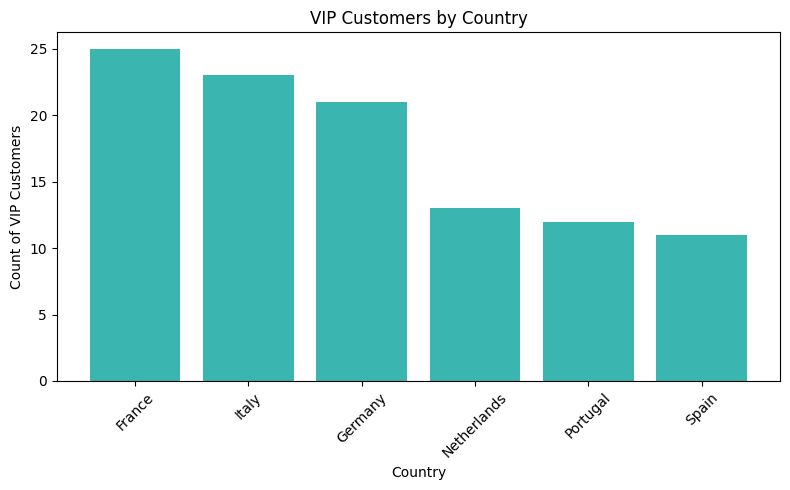

In [98]:

df = pd.read_sql_query(
"""
    SELECT 
        country,
        COUNT(*) as VIP_count
    FROM dataset_fashion_store.vip_customers
    GROUP BY country;

""",
    engine
)

df = df.sort_values(by='VIP_count', ascending=False)
plt.figure(figsize=(8, 5))
plt.bar(df['country'], df['VIP_count'], color='#3AB5B0') 
plt.title('VIP Customers by Country')
plt.xlabel('Country')
plt.ylabel('Count of VIP Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify the age range that most customers belong to 
- by revenue created
- Goal: adjust the language used in the next sales campaign
- serious for older people and fun and energetic for younger audiences

In [ ]:
# Identify the age range that most customers belong to in order to adjust the language used in the next sales campaign - go by revenue created
# (serious for older people and fun and energetic for younger audiences)

# created a VIEW in MySQL Workbench to make python selection easier:

"""
CREATE VIEW age_ranges_with_revenue AS 
	SELECT 
		age_range,
		COUNT(DISTINCT(c.customer_id)) as customer_count,
		ROUND(SUM(total_amount), 2) as total_revenue
	FROM 
		customers as c
	JOIN 
		sales as s
	ON s.customer_id = c.customer_id
	GROUP BY age_range
	ORDER BY total_revenue DESC 
"""

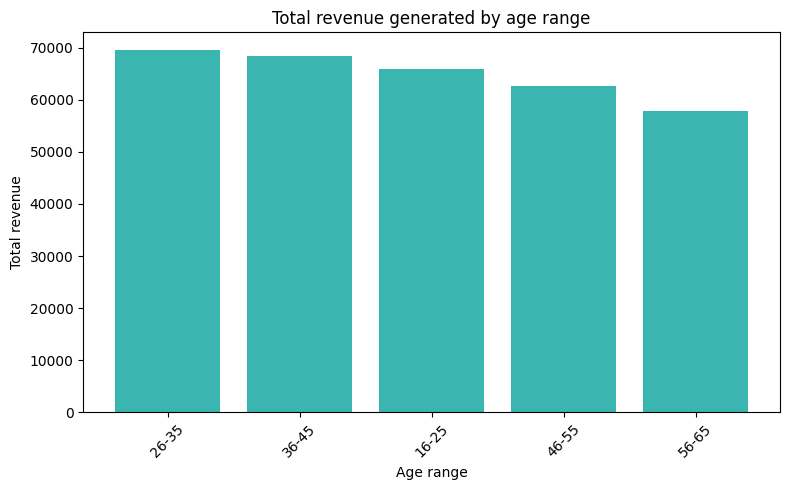

In [102]:
# Identify the age range that most customers belong to in order to adjust the language used in the next sales campaign - go by revenue created
# (serious for older people and fun and energetic for younger audiences)
df = pd.read_sql_query(
"""
    SELECT * FROM dataset_fashion_store.age_ranges_with_revenue;

""",
    engine
)

df = df.sort_values(by='total_revenue', ascending=False)
plt.figure(figsize=(8, 5))
plt.bar(df['age_range'], df['total_revenue'], color='#3AB5B0') 
plt.title('Total revenue generated by age range')
plt.xlabel('Age range')
plt.ylabel('Total revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# What percentage of our registered users are active?

In [ ]:
# What percentage of our registered users are active?

# created a VIEW in MySQL Workbench to make python selection easier:

"""
CREATE OR REPLACE VIEW percentage_active_customers AS 
	SELECT
		COUNT(DISTINCT(c.customer_id)) as total_customers,
		COUNT(DISTINCT CASE WHEN sale_id IS NULL THEN c.customer_id END) as inactive_customers,
		COUNT(DISTINCT CASE WHEN sale_id IS NOT NULL THEN c.customer_id END) as active_customers,
		COUNT(DISTINCT CASE WHEN sale_id IS NOT NULL THEN c.customer_id END)  / COUNT(DISTINCT(c.customer_id)) as percentage_active_customers
	FROM customers as c 
	LEFT JOIN sales as s
	ON c.customer_id = s.customer_id
"""

   total_customers  inactive_customers  active_customers  \
0             1000                 420               580   

   percentage_active_customers  
0                         0.58  


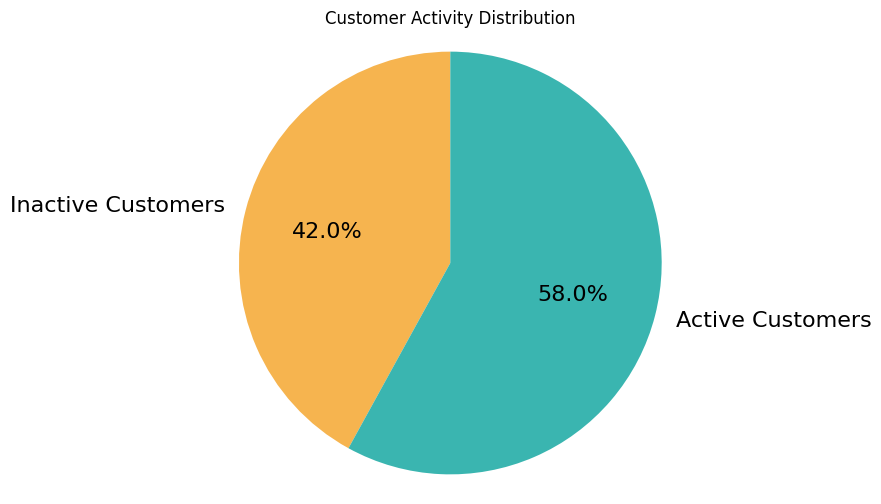

In [106]:
df = pd.read_sql_query(
"""
    SELECT * FROM dataset_fashion_store.percentage_active_customers;

""",
    engine
)
print(df)
labels = ['Inactive Customers', 'Active Customers']
sizes = [df.loc[0, 'inactive_customers'], df.loc[0, 'active_customers']]
colors = ['#F6B44F', '#3AB5B0']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 16})
plt.title('Customer Activity Distribution')
plt.axis('equal')

plt.show()

# Determine stock value / sunk cost

In [ ]:
# Determine stock value / sunk cost

# created a VIEW in MySQL Workbench to make python selection easier:

"""
CREATE OR REPLACE VIEW stock_value AS
	SELECT 
		gender,
		country,
		ROUND(SUM(catalog_price * stock_quantity), 2) as total_stock_value,
		ROUND(SUM(cost_price * stock_quantity), 2) as total_sunk_cost,
		ROUND(AVG(stock_quantity), 2) as avg_quantity
	FROM 
		stock as st
	LEFT JOIN products as p
	ON p.product_id = st.product_id
	GROUP BY country, gender;
"""

   gender  country  total_stock_value  total_sunk_cost  avg_quantity
0  Female   France         1207101.92        663077.39         48.27
1  Female  Germany           24939.02         13724.41          1.00


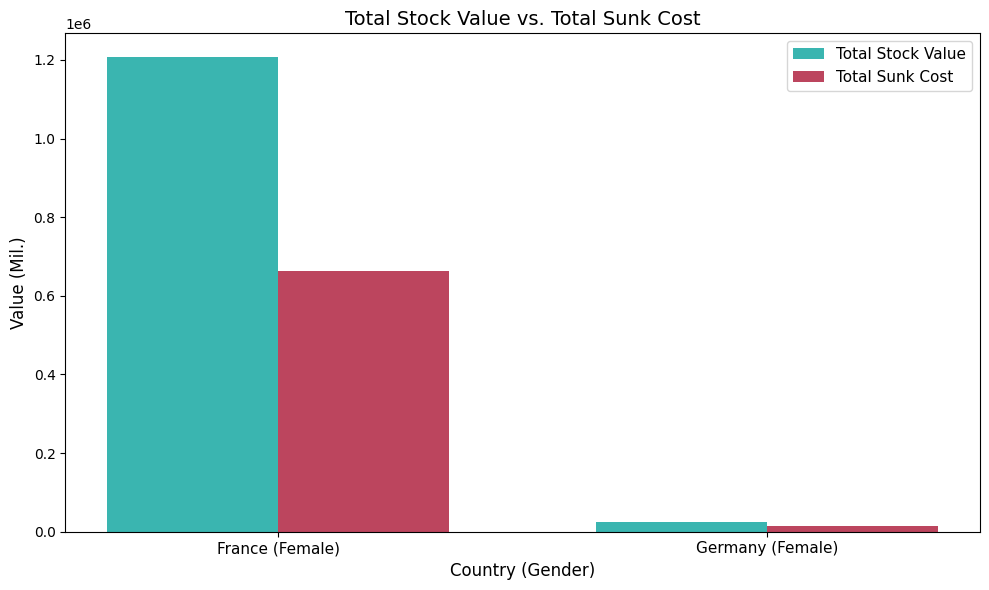

In [109]:
df = pd.read_sql_query(
"""
    SELECT * FROM dataset_fashion_store.stock_value;

""",
    engine
)
print(df)

x = df['country'] + ' (' + df['gender'] + ')'
stock_values = df['total_stock_value']
sunk_costs = df['total_sunk_cost']

x_labels = x.tolist()
x_indexes = range(len(x_labels))

plt.figure(figsize=(10, 6))
bar_width = 0.35

# Bars for total stock value and sunk cost
plt.bar([i - bar_width/2 for i in x_indexes], stock_values, width=bar_width, label='Total Stock Value', color='#3AB5B0')
plt.bar([i + bar_width/2 for i in x_indexes], sunk_costs, width=bar_width, label='Total Sunk Cost', color='#BC455E')

plt.xlabel('Country (Gender)', fontsize=12)
plt.ylabel('Value (Mil.)', fontsize=12)
plt.title('Total Stock Value vs. Total Sunk Cost', fontsize=14)
plt.xticks(ticks=x_indexes, labels=x_labels, fontsize=11)
plt.legend(fontsize=11)
plt.tight_layout()

plt.show()

# Find the total percentage of revenue by customers who are in 95th percentile by spendings compared to all revenue 
- Do our top spenders dominate our market, is there a heavy tail?

In [ ]:
# Find the total percentage of revenue by customers who are in 95th percentile by spendings compared to all revenue 
# (Do our top spenders dominate our market, is there a heavy tail?)

# created a VIEW in MySQL Workbench to make python selection easier:

"""
CREATE OR REPLACE VIEW revenue_top_5_spenders AS 
	WITH customer_percentiles AS (
		SELECT
			 s.customer_id,
			 sum(total_amount) as total_amount,
			 PERCENT_RANK() OVER (ORDER BY sum(total_amount) ) AS pct_rank
		FROM
			customers as c
		JOIN 
			sales as s
		ON s.customer_id = c.customer_id
		GROUP BY s.customer_id
		)
	SELECT 
		ROUND(SUM(total_amount), 2)  as total_revenue,
		ROUND(SUM(CASE WHEN pct_rank >= 0.95 THEN total_amount END), 2) AS revenue_top_5_percentile,
		ROUND(SUM(CASE WHEN pct_rank < 0.95 THEN total_amount END), 2)  as revenue_lower_95_percentle,
		ROUND(SUM(CASE WHEN pct_rank >= 0.95 THEN total_amount END) / SUM(total_amount), 2) as top_5_of_total
	 FROM customer_percentiles;
"""

  percentile_source  total_revenue  revenue_top_5_percentile  \
0          customer      324236.66                  45882.67   

   revenue_lower_95_percentle  top_5_of_total  
0                   278353.99            0.14  


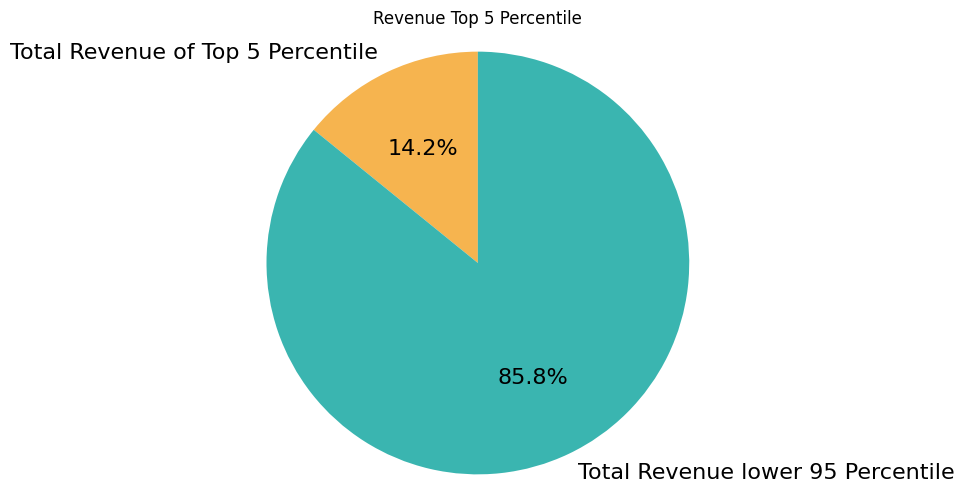

In [ ]:
df = pd.read_sql_query(
"""
    SELECT * FROM dataset_fashion_store.revenue_top_5_spenders;

""",
    engine
)

print(df)
labels = ['Total Revenue of Top 5 Percentile', 'Total Revenue lower 95 Percentile']
sizes = [df.loc[0, 'revenue_top_5_percentile'], df.loc[0, 'revenue_lower_95_percentle']]
colors = ['#F6B44F', '#3AB5B0']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 16})
plt.title('Revenue Top 5 Percentile by customer_id')
plt.axis('equal')

plt.show()

# Find the total percentage of revenue by product and brand who are in 95th percentile by spendings compared to all revenue 
- do we have have top products/brands and the rest aren’t selling much
- There is only one brand in the data: 'Tiva' so I will focus on product_id

In [ ]:
# Find the total percentage of revenue by customers who are in 95th percentile by spendings compared to all revenue 
# -- The same for products or brands — do we have have top products/brands and the rest aren’t selling much
# -- There is only one brand in the data: 'Tiva' so I will focus on product_id

# created a VIEW in MySQL Workbench to make python selection easier:

"""
CREATE OR REPLACE VIEW revenue_top_5_products AS 
	WITH product_percentile AS (
		SELECT
			p.product_id,
			sum(si.item_total) as total_amount,
			PERCENT_RANK() OVER (ORDER BY  sum(si.item_total)  ) AS pct_rank
		FROM 
			salesitems as si
		JOIN products as p
		ON p.product_id = si.product_id
		GROUP BY p.product_id
		)
	SELECT 
	"product_id" as percentile_source, 
		ROUND(SUM(total_amount), 2)  as total_revenue,
		ROUND(SUM(CASE WHEN pct_rank >= 0.95 THEN total_amount END), 2) AS revenue_top_5_percentile,
		ROUND(SUM(CASE WHEN pct_rank < 0.95 THEN total_amount END), 2)  as revenue_lower_95_percentle,
		ROUND(SUM(CASE WHEN pct_rank >= 0.95 THEN total_amount END) / SUM(total_amount), 2) as top_5_of_total
	 FROM product_percentile;
"""

  percentile_source  total_revenue  revenue_top_5_percentile  \
0        product_id      324236.66                  39325.54   

   revenue_lower_95_percentle  top_5_of_total  
0                   284911.12            0.12  


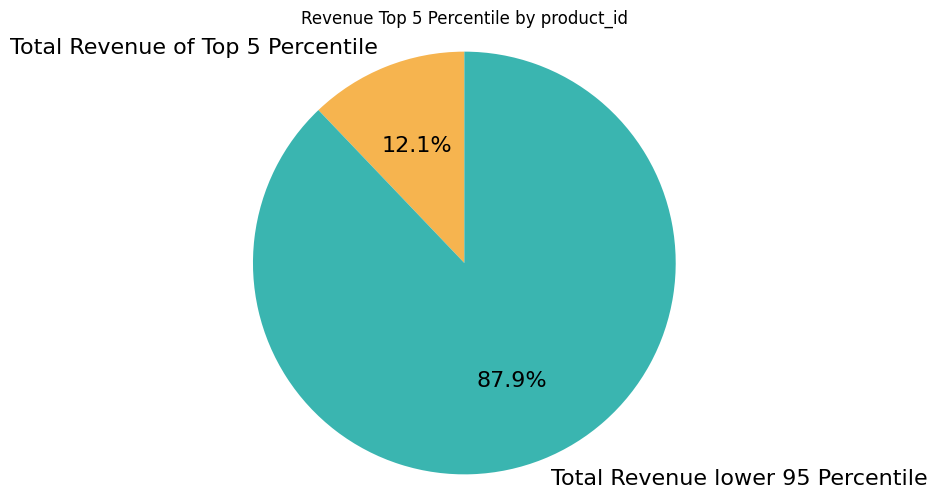

In [115]:
df = pd.read_sql_query(
"""
    SELECT * FROM dataset_fashion_store.revenue_top_5_products;

""",
    engine
)

print(df)
labels = ['Total Revenue of Top 5 Percentile', 'Total Revenue lower 95 Percentile']
sizes = [df.loc[0, 'revenue_top_5_percentile'], df.loc[0, 'revenue_lower_95_percentle']]
colors = ['#F6B44F', '#3AB5B0']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 16})
plt.title('Revenue Top 5 Percentile by product_id')
plt.axis('equal')

plt.show()